In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
from weighted_levenshtein import lev
import time

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import (streaming_classifier,
                                   three_pronged_smoothing_classifier,
                                   #two_pronged_smoothing_classifier,
                                   one_pronged_smoothing_classifier,
                                   zeroes_classifier,
                                   catch22_knn_classifier)


In [2]:

waves, labels, samprate = load_training_data(path = "/Users/darap/Documents/School/University/2021, Sem. 1/DATA3888/Aqua10/Datasets/Good Data - Sandeep no errors/",
                       scale_factor= 512/(2**13 - 1),
                       blacklist = ["blink", "different", "fast", "slow", "eyebrow", "left-right-middle-sandeep", "left-right-middle-marina"])


dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'right-middle']) dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'right-middle'])
c:\Users\darap\Documents\School\University\2021, Sem. 1\DATA3888\Aqua10\Classifier\load_data.py:68: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


One-pronged
time taken:  0.3695361614227295
done
Three-pronged
time taken:  0.35402607917785645
done
Zeroes classifier
time taken:  0.26501965522766113
done
KNN classifier
time taken:  0.7911028861999512
done
Nil classifier
time taken:  0.24001789093017578
done
total length:  102


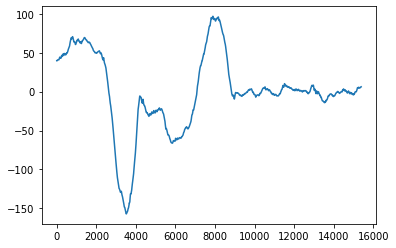

In [5]:
# Set parameters such that event detection window lands in the middle of the signal

hyp_event_smart_threshold_window = 5
hyp_event_smart_threshold_factor = 5

hyp_detection_buffer_end = 0.6
hyp_detection_buffer_start = 0.2


det_window = 0.6432

window_size = det_window + hyp_detection_buffer_end + hyp_detection_buffer_start

N_loops_over_window = 15

buffer_size = window_size/N_loops_over_window

hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))
#print(hyp_consecutive_triggers)




# fig, ax = plt.subplots(len(waves), 1)
# fig.set_size_inches(15, 3*len(waves))



classifiers = {"One-pronged": one_pronged_smoothing_classifier,
               "Three-pronged": three_pronged_smoothing_classifier,
               #"Two-pronged": two_pronged_smoothing_classifier,
               "Zeroes classifier": zeroes_classifier,
               "KNN classifier": catch22_knn_classifier,
               "Nil classifier": zeroes_classifier #won't use the classifier, but need placeholder
               }

all_classification_times = {}
better_all_classification_times = {}
nil = False
using_zeroes = False
for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    start = time.time()
    if classifier_label == "Nil classifier":
        nil = True
    else:
        nil = False
    if classifier_label == "Zeroes classifier":
        using_zeroes = True
    else:
        using_zeroes = False
    for i, key in enumerate(waves):
        predictions, predictions_timestamps, predictions_storage, times = streaming_classifier(
            waves[key], # Either the array from file (or ser if live = True)
            samprate,
            classifier = classifier, 
            using_zeroes_classifier = using_zeroes,
            plot_zeroes_classifier = using_zeroes,
            window_size = window_size, # Total detection window [s]
            N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
            hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off end of the window in order to define the middle portion
            hyp_detection_buffer_start = hyp_detection_buffer_start, # seconds - how much time to shave off start of the window in order to define the middle portion
            hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, # The length of the calibration period to define the threshold
            hyp_calibration_statistic_function = np.std, # Function that calculates the calibration statistic
            hyp_test_statistic_function = lambda x: np.max(x) - np.min(x), # Function that calculates the test statistic
            hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, # The scale factor of the calibration range that will become the threshold
            hyp_event_history = hyp_consecutive_triggers+1, # How many historical event detection results are kept in memory (whether the test criteria failed or passed)
            hyp_consecutive_triggers = hyp_consecutive_triggers, # How many threshold triggers need to occur in a row for an event to be called
            hyp_consecutive_reset = 1, # How many threshold failures need to occur in a row for the classifier to be primed for a new event
            total_time = None,  # max time. If none, it goes forever!
            plot = False, # Whether to plot the livestream data
            store_events = True, # Whether to return the classification window array for debugging purposes
            store_times = True, # To see how long classification takes
            verbose = False, # lol
            live = False, # Whether we're live
            hyp_timeout = 10,
            nil_classifier = nil,
            timeout = False)

        if classifier_label in better_all_classification_times.keys():
            better_all_classification_times[classifier_label] += times

        else:
            better_all_classification_times[classifier_label] = times
   

        if "times" in all_classification_times.keys():
            all_classification_times["times"].append(times)
            all_classification_times["classifier"].append(classifier_label)
        else:
            all_classification_times["times"] = []
            all_classification_times["classifier"] = []
            all_classification_times["times"].append(times)
            all_classification_times["classifier"].append(classifier_label)
    end = time.time()
    print("time taken: ", end - start)
    print("done")

print("total length: ", len(better_all_classification_times["One-pronged"]))
#     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i,
#                      title="", before_buffer = 0.7, after_buffer = 1, actual_alpha=0.0,
#                      wave_alpha=1, pred_alpha = 0.5, miny = -100, maxy = 100)



In [6]:
import statistics

for key, values in better_all_classification_times.items():
    print("\n\n", key)
    print(values, "\n")
    print("median:", statistics.median(values))
    print("mean: ", np.mean(values))



 One-pronged
[1504400, 2004900, 1995200, 999900, 1001200, 1002500, 2002400, 999500, 1000000, 1000200, 1003600, 1997000, 1006000, 1000500, 2001400, 999000, 1993000, 997900, 2004300, 1000400, 1999500, 1000100, 999100, 1000600, 1000000, 0, 1000200, 1000200, 998800, 1001000, 1003500, 1000200, 1000200, 0, 0, 999800, 997300, 1000300, 0, 1001300, 0, 999500, 998300, 1000100, 0, 1001200, 1001000, 1001000, 999000, 1001500, 2004100, 1000900, 1001200, 999600, 1001000, 1000400, 1995500, 1002600, 2001800, 999100, 998400, 999700, 1000400, 1000300, 0, 0, 1000900, 999200, 999800, 0, 1000600, 0, 999500, 0, 1000000, 1000100, 1000000, 1001300, 999600, 1000300, 0, 0, 999500, 1000300, 999900, 1001600, 997500, 999400, 1000100, 0, 999100, 1000400, 999900, 999300, 1000100, 1000400, 1001400, 1000100, 1000000, 1000100, 1003100, 999800] 

median: 1000100.0
mean:  975738.2352941176


 Three-pronged
[999400, 999100, 1001900, 998900, 1000200, 1000100, 2002700, 1999900, 999900, 1000100, 999600, 1997400, 1000000, 10

In [49]:
#Please ignore below code, was me trying to make a boxplot and failing
"""
import seaborn as sns

#print(all_classification_times)

df = pd.DataFrame(all_classification_times)
df_melt = df.melt(id_vars = "classifier",
                  value_vars = ["times"],
                  var_name = "columns")
print(df_melt)
""" 

         classifier columns                                              value
0       One-pronged   times  [0.0019998550415039062, 0.0019991397857666016,...
1     Three-pronged   times  [0.0010001659393310547, 0.001001119613647461, ...
2  Zeros classifier   times  [0.0, 0.0010042190551757812, 0.0, 0.0, 0.0, 0....
3    KNN classifier   times  [0.005000591278076172, 0.006000518798828125, 0...


C:\Users\darap\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


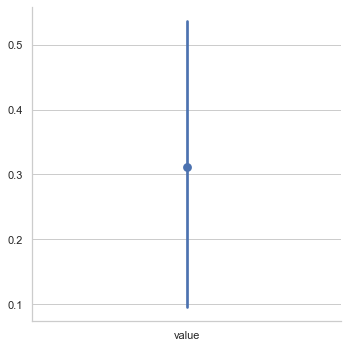

In [55]:
"""
b = sns.boxplot(data = df_melt,
                id_vars = 'classifier')

plt.show()
"""

         cls      columns     value
0        sig     accuracy  1.526892
1        sig     accuracy -0.933579
2        sig     accuracy  1.104943
3        sig     accuracy -0.357584
4        sig     accuracy  1.774882
5   baseline     accuracy  1.518440
6   baseline     accuracy -0.841208
7   baseline     accuracy  0.558067
8   baseline     accuracy  0.875176
9   baseline     accuracy  1.216856
10       sig          auc  0.808267
11       sig          auc  0.512939
12       sig          auc  1.641194
13       sig          auc  1.110042
14       sig          auc  0.049984
15  baseline          auc  0.802825
16  baseline          auc  0.247575
17  baseline          auc  0.983581
18  baseline          auc  0.666456
19  baseline          auc  0.840221
20       sig          ppv  0.937752
21       sig          ppv  0.100591
22       sig          ppv -0.747021
23       sig          ppv -0.707902
24       sig          ppv -0.048321
25  baseline          ppv -0.352922
26  baseline          ppv  0

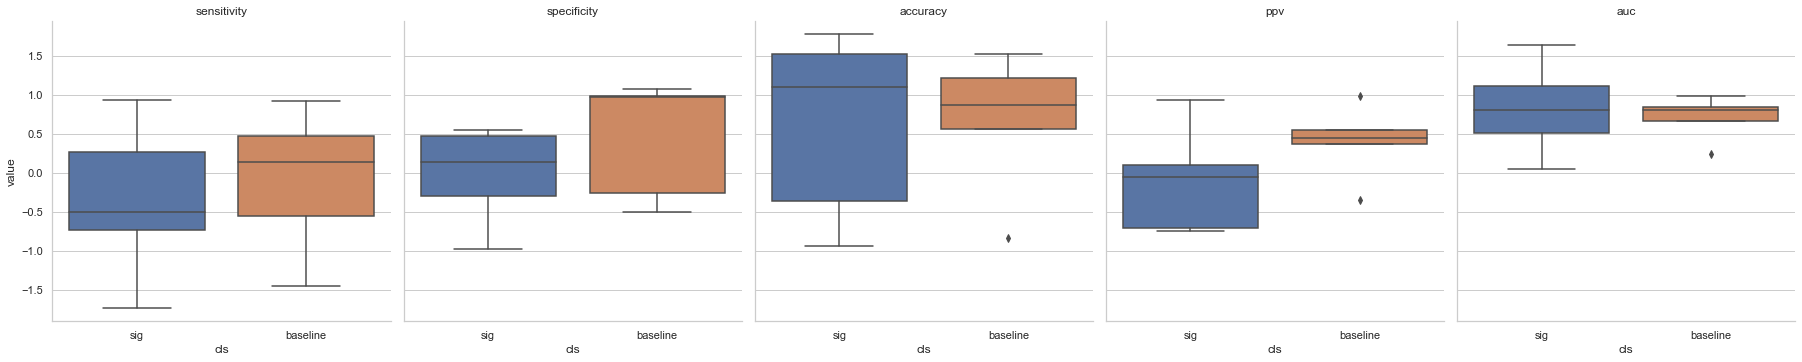

In [53]:
"""
data = {'sensitivity' : np.random.normal(loc = 0, size = 10),
        'specificity' : np.random.normal(loc = 0, size = 10),
        'accuracy' : np.random.normal(loc = 0, size = 10),
        'ppv' : np.random.normal(loc = 0, size = 10),
        'auc' : np.random.normal(loc = 0, size = 10),
        'cls' : ['sig', 'sig', 'sig', 'sig', 'sig', 'baseline', 'baseline', 'baseline', 'baseline', 'baseline']}

df = pd.DataFrame(data)

df_melt = df.melt(id_vars = 'cls',
                  value_vars = ['accuracy',
                                'auc',
                                'ppv',
                                'sensitivity',
                                'specificity'],
                  var_name = 'columns')
print(df_melt)
a = sns.factorplot(data = df_melt,
                   x = 'cls',
                   y = 'value',
                   kind = 'box', # type of plot
                   col = 'columns',
                   col_order = ['sensitivity', # custom order of boxplots
                                'specificity',
                                'accuracy',
                                'ppv',
                                'auc']).set_titles('{col_name}') # remove 'column = ' part of title

plt.show()
"""